# **Проект e-commerce:**
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. (10 баллов)

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут. (35 баллов)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### **olist_customers_dataset - таблица с уникальными идентификаторами пользователей**

customer_id — позаказный идентификатор пользователя (аналог номера паспорта)  
customer_unique_id —  уникальный идентификатор пользователя  
customer_zip_code_prefix —  почтовый индекс пользователя  
customer_city —  город доставки пользователя  
customer_state —  штат доставки пользователя  

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
                 #encoding='windows-1251', sep=';') 
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### **olist_orders_dataset.csv —  таблица заказов**

order_id —  уникальный идентификатор заказа (номер чека)  
customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)  
order_status —  статус заказа  
order_purchase_timestamp —  время создания заказа  
order_approved_at —  время подтверждения оплаты заказа  
order_delivered_carrier_date —  время передачи заказа в логистическую службу  
order_delivered_customer_date —  время доставки заказа  
order_estimated_delivery_date —  обещанная дата доставки  

In [3]:
orders = pd.read_csv('olist_orders_dataset.csv')
                 #encoding='windows-1251', sep=';') 
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### **olist_order_items_dataset.csv —  товарные позиции, входящие в заказы**

order_id —  уникальный идентификатор заказа (номер чека)  
order_item_id —  идентификатор товара внутри одного заказа  
product_id —  ид товара (аналог штрихкода)  
seller_id — ид производителя товара  
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
price —  цена за единицу товара  
freight_value —  вес товара  

In [4]:
items = pd.read_csv('olist_order_items_dataset.csv')
                 #encoding='windows-1251', sep=';') 
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Уникальные статусы заказов в таблице olist_order_items_dataset:

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

Проверим, есть ли в наших данных пропущенные значения и дубликаты.

In [5]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [7]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [8]:
print(orders.duplicated().sum())
print(customers.duplicated().sum())
print(items.duplicated().sum())

0
0
0


Дубликатов нет, однако есть пропущенные значения в столбцах в таблице orders:   
order_approved_at — время подтверждения оплаты заказа  
order_delivered_carrier_date — время передачи заказа в логистическую службу    
order_delivered_customer_date — время доставки заказа  

Скорее всего, это связано с тем, что еще не все заказы были доставлены до пункта назначения. Так что эти данные не удаляем.

### Задание 1
### Сколько у нас пользователей, которые совершили покупку только один раз?

1. К таблице orders приджойнить таблицу customers, чтобы появилось поле customer_unique_id
2. Отфильтровать заказы в статусе created, т.к. они еще не оплачены и не явяются покупками (в целом допустимо любое удаление статусов с аргументами)
3. Для каждого уникального покупателя рассчитать суммарное количество заказов, которые были сделаны
4. Отфильтровать покупателей, у которых только 1 заказ
5. Рассчитать количество уникальных покупателей

In [9]:
# уникальные статусы заказа

orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [10]:
# к таблице orders приджойнили таблицу customers, чтобы появилось поле customer_unique_id

orders_merge = orders.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')
orders_merge

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c


In [11]:
# убрали отмененные и недоступные заказы

orders_delivery = orders_merge.query('order_status not in ("canceled", "unavailable")')
orders_delivery

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c


In [12]:
# кол-во пользователей, сделавших заказ

orders_delivery \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.nunique() \
    .customer_unique_id.nunique()

94990

In [13]:
# Отфильтровать покупателей, у которых только 1 заказ

orders_delivery \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.nunique() \
    .query('order_id == 1')

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,1
94986,fffea47cd6d3cc0a88bd621562a9d061,1
94987,ffff371b4d645b6ecea244b27531430a,1
94988,ffff5962728ec6157033ef9805bacc48,1


In [14]:
#количество уникальных пользователей

orders_delivery \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.nunique() \
    .query('order_id == 1') \
    .customer_unique_id.nunique()

92102

In [15]:
round((orders_delivery \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.nunique() \
    .query('order_id == 1') \
    .customer_unique_id.nunique())/(orders_delivery \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.nunique() \
    .customer_unique_id.nunique()) * 100, 2)

96.96

ОТВЕТ:

Количество уникальных пользователей, которые совершили покупку только один раз — 92102. 

Это 96,96% от общего числа.

### Задание 2
### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

1. Отфильтровать те заказы, статус которых соответствует негативному событию
2. Рассчитать месяц на основе дат (отрезать год и месяц)
3. Для каждого месяца и каждого негативного статуса рассчитать уникальное количество заказов
4. Для каждого статуса рассчитать среднее количество заказов по месяцам.

In [16]:
#распределение заказов по статусам

orders_count = orders.order_status.value_counts()
orders_count

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

In [17]:
# распределение не доставленных заказов

status = orders.groupby('order_status') \
                .agg({'order_id' : 'count'}) \
                .reset_index() \
                .query('order_status != "delivered"')
status

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


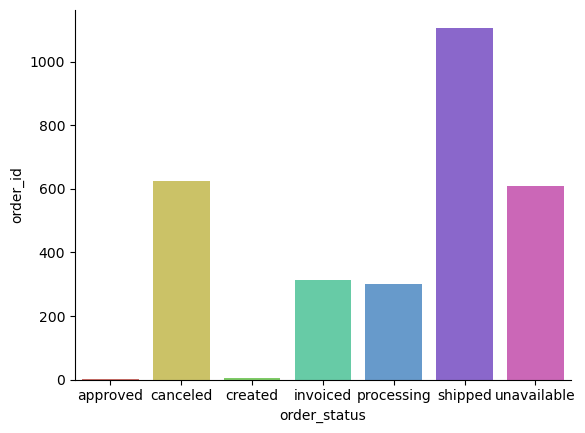

<Figure size 2000x1400 with 0 Axes>

In [18]:
sns.barplot(x=status['order_status'],y=status['order_id'],data=status,palette='hls')
sns.despine()
fig = plt.figure(figsize=(20,14))

In [19]:
orders_merge_canceled_un = orders_merge.query("order_status in ('canceled', 'unavailable')")
orders_merge_canceled_un

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,41fc647b8c6bd979b1b6364b60471b50
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaN,NaN,2018-08-14 00:00:00,8ea097b1824dbd4d17af71b0afe04301
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,0e634b16e4c585acbd7b2e8276ce6677
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22 00:00:00,c4ebedb09beb89cc0314c5c0c33f8053
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,596ed6d7a35890b3fbac54ec01f69685
...,...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,a33e0969408919ba06779f497ead93ec
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,e90598185d2427a35e32ef241a5c04aa
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,d05c44a138277ad325d915c6b7ccbcdf
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00,e72a90a2b29fe1a8795b284aaaa3246f


In [20]:
orders_merge_canceled_un.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
customer_unique_id               object
dtype: object

In [21]:
orders_merge_canceled_un['order_purchase_timestamp'] = orders_merge_canceled_un['order_purchase_timestamp'].astype('datetime64')

C:\Users\Марина\AppData\Local\Temp\ipykernel_2524\582948254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_merge_canceled_un['order_purchase_timestamp'] = orders_merge_canceled_un['order_purchase_timestamp'].astype('datetime64')


In [22]:
orders_merge_canceled_un.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
customer_unique_id                       object
dtype: object

In [23]:
orders_merge_canceled_un['year_month'] = orders_merge_canceled_un['order_purchase_timestamp'].dt.strftime('%Y/%m')

C:\Users\Марина\AppData\Local\Temp\ipykernel_2524\1474522981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_merge_canceled_un['year_month'] = orders_merge_canceled_un['order_purchase_timestamp'].dt.strftime('%Y/%m')


In [24]:
orders_merge_canceled = orders_merge_canceled_un.query("order_status =='canceled'")
orders_merge_canceled

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,year_month
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaN,NaN,2018-08-14 00:00:00,8ea097b1824dbd4d17af71b0afe04301,2018/08
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22 00:00:00,c4ebedb09beb89cc0314c5c0c33f8053,2018/01
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaN,2018-02-23 00:00:00,11c3d6c93dea6ce86769a4835c171bd9,2018/01
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,4fa4365000c7090fcb8cad5713c6d3db,2018/08
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00,08642cd329066fe11ec63293f714f2f8,2018/09
...,...,...,...,...,...,...,...,...,...,...
98791,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaN,NaN,2017-03-30 00:00:00,78a159045124eb7601951b917a42034f,2017/03
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaN,NaN,NaN,2018-08-10 00:00:00,13d7bd0b05e18b00f415221b3bb69348,2018/08
99143,6560fb10610771449cb0463c5ba12199,0d07d0a588caf93cc66b7a8aff86d2fe,canceled,2017-10-01 22:26:25,2017-10-01 22:35:22,NaN,NaN,2017-10-27 00:00:00,0f75924cbbe60142068f4029d744b724,2017/10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,e90598185d2427a35e32ef241a5c04aa,2018/08


In [25]:
orders_merge_unavailable = orders_merge_canceled_un.query("order_status =='unavailable'")
orders_merge_unavailable

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,year_month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,41fc647b8c6bd979b1b6364b60471b50,2017/11
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,0e634b16e4c585acbd7b2e8276ce6677,2018/01
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,596ed6d7a35890b3fbac54ec01f69685,2017/08
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,2349bbb558908e0955e98d47dacb7adb,2018/01
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaN,2017-10-27 00:00:00,21c933c8dd97d088e64c50988c90ccf5,2017/09
...,...,...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaN,NaN,2017-10-27 00:00:00,9004096d8ffc515d4189e661fc4bcb84,2017/10
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaN,NaN,2018-01-19 00:00:00,0aa3b096dc796c251f9b36a822051ed6,2017/12
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,a33e0969408919ba06779f497ead93ec,2018/01
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00,e72a90a2b29fe1a8795b284aaaa3246f,2017/08


In [26]:
omc_count = orders_merge_canceled.groupby(['year_month']).agg({'order_status':'count'}).reset_index()
omc_count

,year_month,order_status
0,2016/09,2
1,2016/10,24
2,2017/01,3
3,2017/02,17
4,2017/03,33
5,2017/04,18
6,2017/05,29
7,2017/06,16
8,2017/07,28
9,2017/08,27


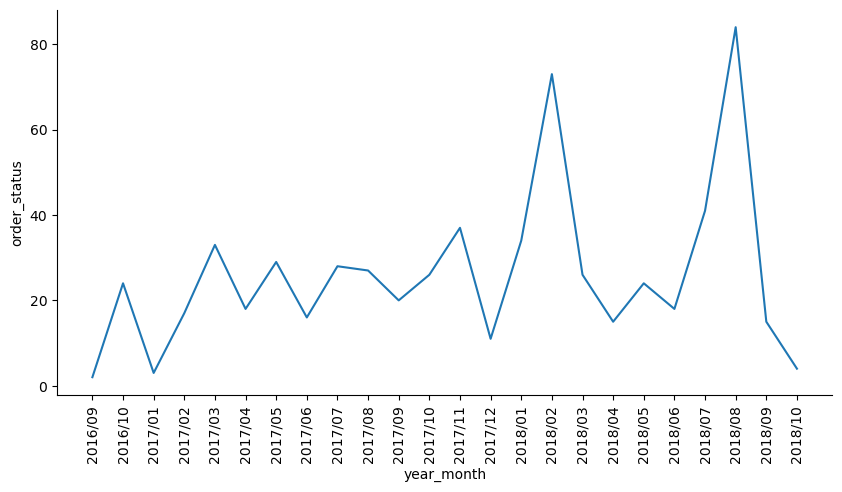

In [27]:
# построим график lineplot

plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(x='year_month', y='order_status', data=omc_count)
sns.despine()

In [28]:
omu_count = orders_merge_unavailable.groupby(['year_month']).agg({'order_status':'count'}).reset_index()
omu_count

,year_month,order_status
0,2016/10,7
1,2017/01,10
2,2017/02,45
3,2017/03,32
4,2017/04,9
5,2017/05,31
6,2017/06,24
7,2017/07,52
8,2017/08,32
9,2017/09,38


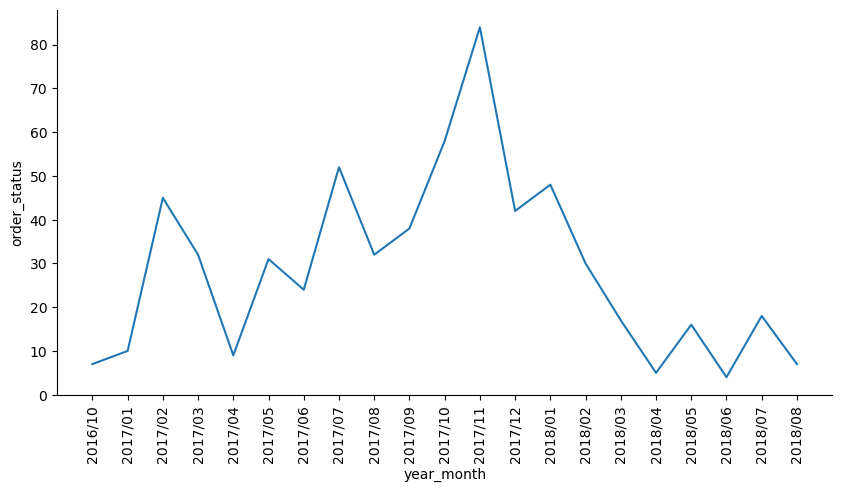

In [29]:
# построим график lineplot

plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(x='year_month', y='order_status', data=omu_count)
sns.despine()

In [30]:
#среднее значение количества отмененных заказов

round(omc_count.order_status.mean(),2)

26.04

In [31]:
#среднее значение количества недоступных заказов

round(omu_count.order_status.mean(),2)

29.0

ОТВЕТ:  
    Среднее количество отмененных заказов: 26,04    
    Среднее количество недоступных заказов: 29,00

### Задание 3
### По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [32]:
orders_items = pd.merge(orders, items, how='left', on='order_id').query('order_status =="delivered"')
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [33]:
orders_items.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
dtype: object

In [34]:
orders_items['order_purchase_timestamp'] = orders_items['order_purchase_timestamp'].astype('datetime64')

In [35]:
orders_items['day_of_the_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

In [36]:
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_the_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [37]:
orders_items.product_id.nunique()

32216

In [38]:
# Нужно найти моду столбца 'day_of_the_week'
# Мода представляет значение, которое чаще всего встречается в наборе данных.

products_with_day_of_the_week = orders_items.groupby('product_id', as_index=False) \
                                               .agg({'day_of_the_week': pd.Series.mode})

In [39]:
products_with_day_of_the_week

,product_id,day_of_the_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32212,fff81cc3158d2725c0655ab9ba0f712c,Monday
32213,fff9553ac224cec9d15d49f5a263411f,Friday
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


### Задание 4
### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть

In [40]:
avg_buys = orders[orders['order_status'].isin(['delivered'])] \
                .merge(customers, how='left', on='customer_id') \
                [['customer_id', 'customer_unique_id', 'order_id', 'order_purchase_timestamp']]
avg_buys.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [41]:
avg_buys.dtypes

customer_id                 object
customer_unique_id          object
order_id                    object
order_purchase_timestamp    object
dtype: object

In [42]:
# поменяем тип данных

avg_buys['order_purchase_timestamp'] = avg_buys['order_purchase_timestamp'].astype('datetime64')

In [43]:
avg_buys.dtypes

customer_id                         object
customer_unique_id                  object
order_id                            object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [44]:
# добавим две колонки: месяц покупки и количество недель в месяце.

avg_buys['month'] = avg_buys.order_purchase_timestamp.dt.month_name()
avg_buys['weeks_in_month'] = round(avg_buys.order_purchase_timestamp.dt.days_in_month / 7, 2)
avg_buys

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,month,weeks_in_month
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,October,4.43
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,July,4.43
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,August,4.43
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,November,4.29
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,February,4.00
...,...,...,...,...,...,...
96473,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,March,4.43
96474,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,February,4.00
96475,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,August,4.43
96476,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,January,4.43


In [45]:
# найдем количество покупок для каждого пользователя по месяцам

avg_buys_orders = avg_buys.groupby(['customer_unique_id', 'order_purchase_timestamp', 'month', 'weeks_in_month'], as_index=False) \
                          .agg({'order_id': 'count'}) \
                          .rename(columns={'order_id': 'orders_by_month'})
avg_buys_orders

,customer_unique_id,order_purchase_timestamp,month,weeks_in_month,orders_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,May,4.43,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,May,4.43,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,March,4.43,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,October,4.43,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,November,4.29,1
...,...,...,...,...,...
96206,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,June,4.29,1
96207,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,December,4.43,1
96208,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,February,4.00,1
96209,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,May,4.43,1


In [46]:
avg_buys_orders['orders_by_week'] = avg_buys_orders.orders_by_month / avg_buys_orders.weeks_in_month
avg_buys_orders

,customer_unique_id,order_purchase_timestamp,month,weeks_in_month,orders_by_month,orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,May,4.43,1,0.225734
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,May,4.43,1,0.225734
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,March,4.43,1,0.225734
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,October,4.43,1,0.225734
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,November,4.29,1,0.233100
...,...,...,...,...,...,...
96206,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,June,4.29,1,0.233100
96207,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,December,4.43,1,0.225734
96208,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,February,4.00,1,0.250000
96209,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,May,4.43,1,0.225734


ОТВЕТ:

In [47]:
avg_buys_week = avg_buys_orders[['customer_unique_id', 'orders_by_week']]
avg_buys_week

,customer_unique_id,orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225734
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225734
2,0000f46a3911fa3c0805444483337064,0.225734
3,0000f6ccb0745a6a4b88665a16c9f078,0.225734
4,0004aac84e0df4da2b147fca70cf8255,0.233100
...,...,...
96206,fffcf5a5ff07b0908bd4e2dbc735a684,0.233100
96207,fffea47cd6d3cc0a88bd621562a9d061,0.225734
96208,ffff371b4d645b6ecea244b27531430a,0.250000
96209,ffff5962728ec6157033ef9805bacc48,0.225734


### Задание №5
### Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. (10 баллов)

Когортный анализ включает в себя следующие этапы:

1. Определение метрики. 
Мы будем считать retention, т.е. количество пользователей, которые вернулись к нашему продукту через N-ое количество времени (в нашем случае, через месяц) после первой покупки.

2. Формирование когорт. 
Мы будем делить пользователей по месяцу покупки.

3. Сравнение когорт и анализ метрик. 

In [48]:
cohorts = orders.merge(customers, how='left', on='customer_id') \
                 [['customer_unique_id', 'order_purchase_timestamp']]

cohorts['order_purchase_timestamp'] = cohorts['order_purchase_timestamp'].astype('datetime64')
cohorts

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39
...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27


In [49]:
# создаем колонку order_month - год и месяц покупки конкретного заказа

cohorts['order_month'] = cohorts['order_purchase_timestamp'].dt.to_period('M')


# создаем колонку join_month - год и месяц первой покупки конкретного пользователя

cohorts['join_month'] = cohorts.groupby('customer_unique_id')['order_purchase_timestamp'] \
                                           .transform('min').dt.to_period('M')
cohorts

,customer_unique_id,order_purchase_timestamp,order_month,join_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02
...,...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03,2017-03
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02,2018-02
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08,2017-08
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01,2018-01


In [50]:
cohorts.dtypes

customer_unique_id                  object
order_purchase_timestamp    datetime64[ns]
order_month                      period[M]
join_month                       period[M]
dtype: object

In [51]:
from operator import attrgetter

In [52]:
# Посчитаем количество месяцев между первой покупкой и датой покупки конкретного заказа

cohorts['period_number'] = (cohorts.order_month - cohorts.join_month).apply(attrgetter('n'))
cohorts

,customer_unique_id,order_purchase_timestamp,order_month,join_month,period_number
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09,1
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02,0
...,...,...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03,2017-03,0
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02,2018-02,0
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08,2017-08,0
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01,2018-01,0


In [53]:
#создадим столбец, в котором далее поместим количество заказов

cohorts.insert(len(cohorts.columns), 'total_orders', 0, allow_duplicates=False)
cohorts

,customer_unique_id,order_purchase_timestamp,order_month,join_month,period_number,total_orders
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09,1,0
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07,0,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08,0,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11,0,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02,0,0
...,...,...,...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03,2017-03,0,0
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02,2018-02,0,0
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08,2017-08,0,0
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01,2018-01,0,0


In [54]:
# сформируем когорты
# посчитаем количество уникальных пользователей и общее количество заказов

cohorts_full = cohorts.groupby(['join_month', 'order_month', 'period_number']) \
                   .agg({'customer_unique_id': pd.Series.nunique, 'total_orders': pd.Series.count}) \
                   .rename(columns={'customer_unique_id': 'total_customers'})
cohorts_full

total_customers  total_orders
join_month order_month period_number                               
2016-09    2016-09     0                            4             4
2016-10    2016-10     0                          321           324
           2017-04     6                            1             1
           2017-07     9                            1             1
           2017-09     11                           1             1
...                                               ...           ...
2018-08    2018-08     0                         6271          6316
           2018-09     1                            7             9
           2018-10     2                            2             2
2018-09    2018-09     0                            5             5
2018-10    2018-10     0                            1             1

[225 rows x 2 columns]

In [55]:
# преобразуем в сводную таблицу.
# в индексах - когорты,
# в столбцах — период после первой покупки,
# в значениях — количество уникальных пользователей, пришедших на данный период после первой покупки

cohort_pivot = cohorts_full.pivot_table(index='join_month',
                                     columns='period_number',
                                     values='total_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
join_month,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [56]:
# Возьмем в отдельную переменную первые значения строк

cohort_size = cohort_pivot.iloc[:,0]
cohort_size

join_month
2016-09       4.0
2016-10     321.0
2016-12       1.0
2017-01     764.0
2017-02    1752.0
2017-03    2636.0
2017-04    2352.0
2017-05    3596.0
2017-06    3139.0
2017-07    3894.0
2017-08    4184.0
2017-09    4130.0
2017-10    4470.0
2017-11    7304.0
2017-12    5487.0
2018-01    7025.0
2018-02    6451.0
2018-03    6965.0
2018-04    6711.0
2018-05    6622.0
2018-06    5940.0
2018-07    6071.0
2018-08    6271.0
2018-09       5.0
2018-10       1.0
Freq: M, Name: 0, dtype: float64

Retention — это метрика, отвечающая на вопрос, сколько людей вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт.

В нашем случае через месяц.

Retention измеряется в процентах, то есть показывает долю вернувшихся людей от изначально пришедших.

Month N Retention = (Users Month N / Users Month 0) * 100

In [57]:
# Поделим значения ячейки на соответствующие им значения и получим таблицу retention

retention = cohort_pivot.divide(cohort_size, axis=0).mul(100).round(2)
retention

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
join_month,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,NaN,NaN,NaN,NaN,NaN,0.31,NaN,NaN,0.31,NaN,0.31,NaN,0.31,NaN,0.31,NaN,0.31,0.62,0.62
2016-12,100.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.39,0.26,0.13,0.39,0.13,0.52,0.13,0.13,NaN,0.39,0.13,0.79,0.39,0.13,0.13,0.26,0.39,0.13,NaN
2017-02,100.0,0.23,0.29,0.11,0.40,0.11,0.23,0.17,0.17,0.23,0.11,0.29,0.17,0.17,0.11,0.06,0.06,0.23,NaN,NaN
2017-03,100.0,0.49,0.38,0.38,0.34,0.15,0.15,0.30,0.34,0.08,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15,NaN,NaN
2017-04,100.0,0.60,0.21,0.17,0.34,0.26,0.34,0.30,0.30,0.17,0.26,0.09,0.09,0.04,0.09,0.09,0.21,NaN,NaN,NaN
2017-05,100.0,0.50,0.50,0.39,0.31,0.33,0.42,0.17,0.25,0.31,0.25,0.33,0.25,0.03,0.19,0.25,NaN,NaN,NaN,NaN
2017-06,100.0,0.48,0.35,0.41,0.25,0.38,0.38,0.22,0.13,0.22,0.32,0.35,0.16,0.13,0.19,NaN,NaN,NaN,NaN,NaN


In [58]:
# Заполним ненужные значения NaN нулем

retention.iloc[0] = retention.iloc[0].fillna(0)
retention.iloc[1] = retention.iloc[1].fillna(0)
retention.iloc[2] = retention.iloc[2].fillna(0)
retention.iloc[3, 9] = 0

In [59]:
retention

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
join_month,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-10,100.0,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.31,0.00,0.31,0.00,0.31,0.00,0.31,0.00,0.31,0.62,0.62
2016-12,100.0,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01,100.0,0.39,0.26,0.13,0.39,0.13,0.52,0.13,0.13,0.00,0.39,0.13,0.79,0.39,0.13,0.13,0.26,0.39,0.13,NaN
2017-02,100.0,0.23,0.29,0.11,0.40,0.11,0.23,0.17,0.17,0.23,0.11,0.29,0.17,0.17,0.11,0.06,0.06,0.23,NaN,NaN
2017-03,100.0,0.49,0.38,0.38,0.34,0.15,0.15,0.30,0.34,0.08,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15,NaN,NaN
2017-04,100.0,0.60,0.21,0.17,0.34,0.26,0.34,0.30,0.30,0.17,0.26,0.09,0.09,0.04,0.09,0.09,0.21,NaN,NaN,NaN
2017-05,100.0,0.50,0.50,0.39,0.31,0.33,0.42,0.17,0.25,0.31,0.25,0.33,0.25,0.03,0.19,0.25,NaN,NaN,NaN,NaN
2017-06,100.0,0.48,0.35,0.41,0.25,0.38,0.38,0.22,0.13,0.22,0.32,0.35,0.16,0.13,0.19,NaN,NaN,NaN,NaN,NaN


In [60]:
# максимальный retention на 3 месяц

max_element = retention[3].max()
max_element

0.41

In [61]:
# Для большей наглядности укажем максимальное значение в каждом столбце

retention.style.highlight_max()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
join_month,,,,,,,,,,,,,,,,,,,,
2016-09,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0.000000,0.310000,0.000000,0.310000,0.000000,0.310000,0.000000,0.310000,0.000000,0.310000,0.620000,0.620000
2016-12,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01,100.000000,0.390000,0.260000,0.130000,0.390000,0.130000,0.520000,0.130000,0.130000,0.000000,0.390000,0.130000,0.790000,0.390000,0.130000,0.130000,0.260000,0.390000,0.130000,nan
2017-02,100.000000,0.230000,0.290000,0.110000,0.400000,0.110000,0.230000,0.170000,0.170000,0.230000,0.110000,0.290000,0.170000,0.170000,0.110000,0.060000,0.060000,0.230000,nan,nan
2017-03,100.000000,0.490000,0.380000,0.380000,0.340000,0.150000,0.150000,0.300000,0.340000,0.080000,0.380000,0.150000,0.230000,0.110000,0.150000,0.230000,0.080000,0.150000,nan,nan
2017-04,100.000000,0.600000,0.210000,0.170000,0.340000,0.260000,0.340000,0.300000,0.300000,0.170000,0.260000,0.090000,0.090000,0.040000,0.090000,0.090000,0.210000,nan,nan,nan
2017-05,100.000000,0.500000,0.500000,0.390000,0.310000,0.330000,0.420000,0.170000,0.250000,0.310000,0.250000,0.330000,0.250000,0.030000,0.190000,0.250000,nan,nan,nan,nan
2017-06,100.000000,0.480000,0.350000,0.410000,0.250000,0.380000,0.380000,0.220000,0.130000,0.220000,0.320000,0.350000,0.160000,0.130000,0.190000,nan,nan,nan,nan,nan


ОТВЕТ:

За 2017 год с января по декабрь самый высокий retention на 3 месяц - 0,41%, и принадлежит он когорте пользователей, которые совершили первую покупку в июне 2017.

В целом Retention очень низкий. Много пользователей, которые совершили покупку только 1 раз.

In [62]:
retention2 = retention.iloc[8:9]
retention2

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
join_month,,,,,,,,,,,,,,,,,,,,
2017-06,100.0,0.48,0.35,0.41,0.25,0.38,0.38,0.22,0.13,0.22,0.32,0.35,0.16,0.13,0.19,NaN,NaN,NaN,NaN,NaN
